In [2]:
import outlaw.nb_util as nb_util
nb_util.setup_nb()
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from numpy import sqrt

rnorm = lambda n: scipy.stats.norm.rvs(size=n)
qnorm = scipy.stats.norm.ppf
pnorm = scipy.stats.norm.cdf

In [3]:
epsilon = .001

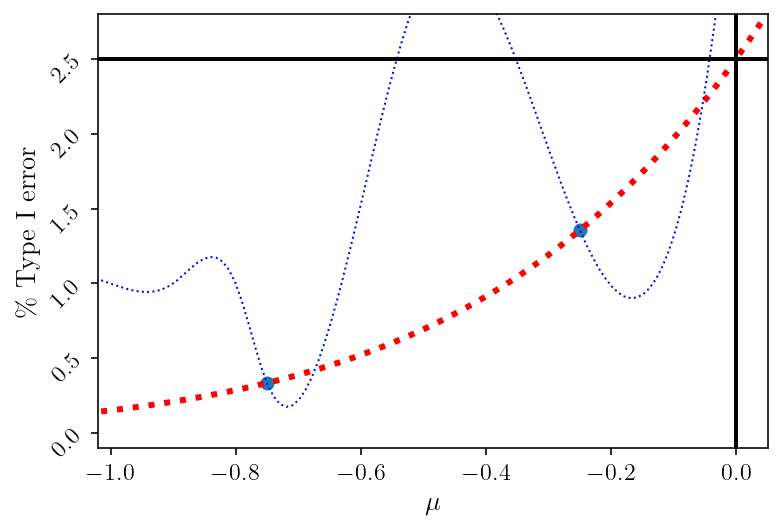

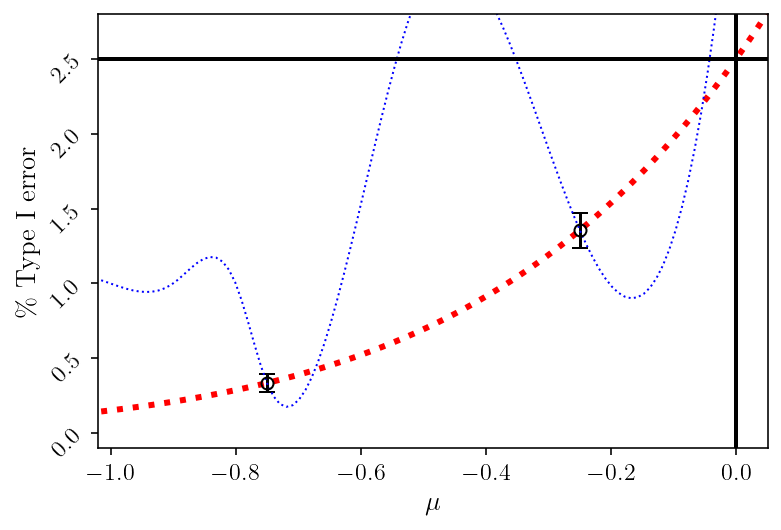

In [42]:
def set_domain(skipx=False, skipy=False):
    if skipx:
        plt.tick_params(
            axis='x',          
            which='both',     
            bottom=False,     
            top=False,        
            labelbottom=False)

    else:
        plt.xlabel('$\mu$')
        plt.xticks(np.linspace(-1, 0, 6))
    if skipy:
        plt.tick_params(
            axis='y',          
            which='both',     
            left=False,     
            right=False,        
            labelleft=False)
    else:
        yticks = np.linspace(0, 0.025, 6)
        plt.yticks(yticks, labels=[f'{(yv * 100):.1f}' for yv in yticks], rotation=45, ha='right')
        plt.ylabel('\% Type I error')
    plt.axvline(x=0, color='k', linewidth=2, linestyle='-')
    plt.axhline(y=0.025, color='k', linewidth=2, linestyle='-')
    plt.xlim([-1.02, 0.05])
    plt.ylim([-0.001, 0.028])
    
def calc_power(npts=None, mu=None, a=-1, b=0, z_thresh=1.96):
    if mu is None:
        mu = np.linspace(a, b, 2 * npts + 1)[1::2]
    power = 1 - scipy.stats.norm.cdf(- mu + z_thresh)
    stepsize = mu[1] - mu[0]
    return mu, power, stepsize

def plot_power_pts(mu, power, error=None, CI=None):
    if error is None:
        plt.plot(mu, power, 'o')
    else:
        plt.errorbar(mu + error, power, yerr = CI, ecolor='k', fmt='o', capsize=4, markeredgecolor='k', markerfacecolor='none')

mu_dense10, pow_dense10, _ = calc_power(100, a=-1.02, b=0)
mu_dense01, pow_dense01, _ = calc_power(100, a=0, b=1)

def fig1(include_ptwise_error, **kwargs):
    mu, power, stepsize = calc_power(2)

    if include_ptwise_error:
        invsn = 1.0 / 100.0
        error = rnorm(len(mu)) * 0.5 * invsn * sqrt(power * (1 - power))
        CI = invsn*sqrt(power * (1 - power))
        plot_power_pts(mu, power, error, CI)
    else:
        plot_power_pts(mu, power)
    plt.plot(mu_dense10, pow_dense10, 'r:', linewidth=3)
    plt.plot(mu_dense01, pow_dense01, 'r:', linewidth=3)
    
    mu_bad = np.append(mu, [-1.1, -1.0, -0.9, -0.8, -0.5, 0.0])
    power_bad = np.append(power, [0.01, 0.01, 0.01, 0.01, 0.03, 0.04])
    interp_f = scipy.interpolate.interp1d(mu_bad, power_bad, kind='cubic')
    plt.plot(mu_dense10, interp_f(mu_dense10), 'b:', linewidth=1)
    set_domain(**kwargs)
fig1(False)
plt.show()
fig1(True)
plt.show()

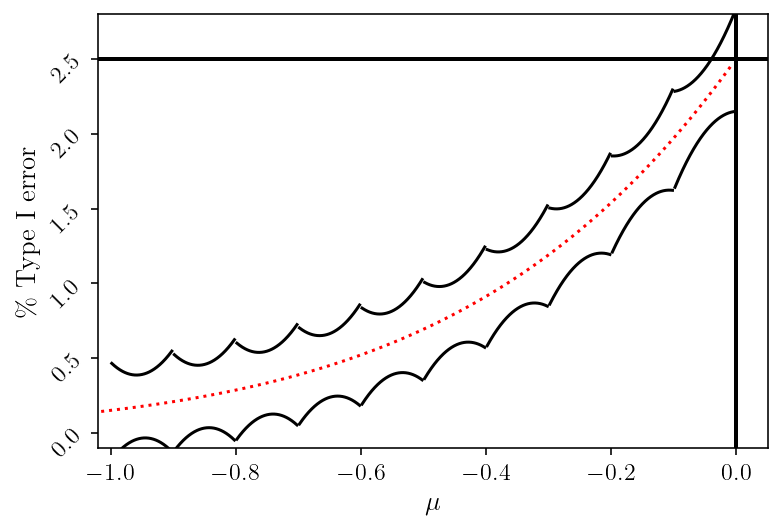

In [43]:
def build_bounds(npts=None, mu=None, nsims=None):
    mu, power, stepsize = calc_power(npts=npts, mu=mu)
    npts = mu.shape[0]

    mu_plus_eps = mu + epsilon
    pow_plus_eps = 1 - pnorm(-mu_plus_eps + 1.96)

    np.random.seed(9)
    # pow_rand = (
    #     power + rnorm(1) / sqrt(nsims) + 2 * sqrt(power * (1 - power) / (nsims))
    # )  # random variance is a bit too large but whatever
    pow_rand = (
        power + rnorm(1) / sqrt(nsims) + 3 * sqrt(0.5 / (nsims))
    )  # random variance is a bit too large but whatever
    pow_rand_low = pow_rand - 6 * sqrt(0.5 / (nsims))
    pow_derivative_rand = (
        (pow_plus_eps - power) / epsilon
        + rnorm(1) / sqrt(nsims)
        + 3 * sqrt(1 / (nsims))
    )  # random variance is a bit too large but whatever
    pow_derivative_rand_low = pow_derivative_rand - 3 * sqrt(
        1 / (nsims)
    )  # random variance is a bit too large but whatever

    penalty_length = 200
    penalized_sequence = np.linspace(-0.48, 0.48, penalty_length)
    penalized_bound = []
    penalized_bound_low = []
    bound_xs = []
    for i in range(npts):
        penalized_bound.append(
            pow_rand[i]
            + pow_derivative_rand[i] * stepsize * penalized_sequence
            + (1 / 2) * (stepsize**2) * (penalized_sequence) ** 2
        )
        penalized_bound_low.append(
            pow_rand_low[i]
            + pow_derivative_rand_low[i] * stepsize * penalized_sequence
            - (1 / 2) * (stepsize**2) * (penalized_sequence) ** 2
        )
        bound_xs.append(mu[i] + stepsize * penalized_sequence)
    return mu, power, stepsize, bound_xs, penalized_bound, penalized_bound_low

mu, power, stepsize, bound_xs, penalized_bound, penalized_bound_low = build_bounds(npts=10, nsims=int(1e6))
for i in range(10):
    plt.plot(bound_xs[i], penalized_bound[i], "k-")
    plt.plot(bound_xs[i], penalized_bound_low[i], "k-")
plt.plot(mu_dense10, pow_dense10, 'r:')
set_domain()
plt.show()


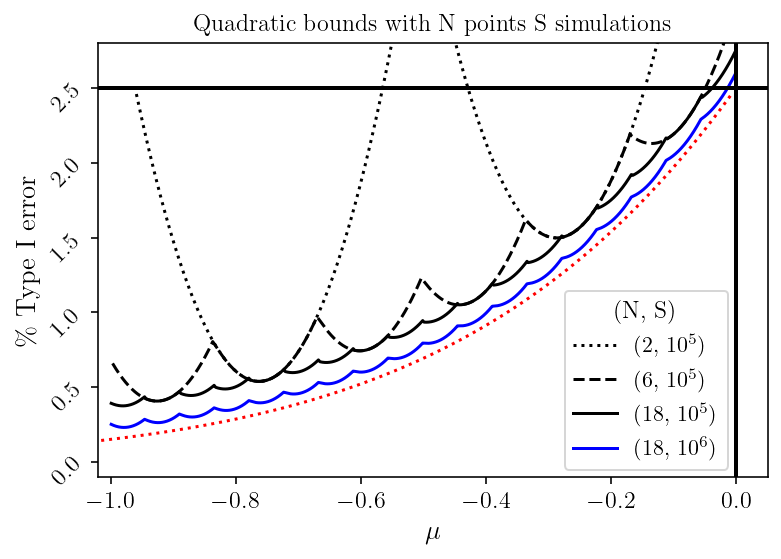

In [44]:
def fig2(**kwargs):
    npts = [2, 6, 18, 18]
    nsims = [int(1e6), int(1e6), int(1e6), int(1e7)]
    linestyle = ['k:', 'k--', 'k-', 'b-']
    for j in range(len(npts)):
        P = npts[j]
        label = f'({P}, $10^5$)' if j < 3 else f'({P}, $10^6$)'
        S = nsims[j]
        # mu, power, stepsize, bound_xs, penalized_bound, penalized_bound_low = build_bounds(mu=mus[j], nsims=int(S))
        mu, power, stepsize, bound_xs, penalized_bound, penalized_bound_low = build_bounds(npts=P, nsims=int(S))
        full_xs = np.concatenate(bound_xs)
        full_bound = np.concatenate(penalized_bound)
        filter = (full_xs > -0.8) | (full_bound < 0.025)
        # filter = (full_bound < 0.025)
        plt.plot(full_xs[filter], full_bound[filter], linestyle[j], label=label)
        # for i in range(P):
        #     plt.plot(bound_xs[i], penalized_bound[i], linestyle[j], label=labels[j])
            # plt.plot(bound_xs[i], penalized_bound_low[i], "k-")
    plt.plot(mu_dense10, pow_dense10, 'r:')
    set_domain(**kwargs)
    plt.legend(loc=(0.697, 0.018), fontsize=11, title='(N, S)', title_fontsize=12)
    # plt.text(-0.16, 0.0094, '(N, S)', zorder=1e6, fontsize=11
fig2()
plt.title('Quadratic bounds with N points S simulations', fontsize=12)
plt.show()

In [45]:
def gradient_bounds(npoints, nsims, include_ptwise_error=False):
    mu, power, stepsize = calc_power(npoints)
    mu_plus_eps = mu + epsilon
    pow_plus_eps = 1 - pnorm(-mu_plus_eps + qnorm(0.975))
    pow_derivative = (pow_plus_eps - power) / epsilon
    pow_derivative_rand = pow_derivative + rnorm(len(power)) / sqrt(nsims)

    invsn = 1.0 / 100.0
    if include_ptwise_error:
        error = rnorm(len(mu)) * 0.5 * invsn * sqrt(power * (1 - power))
        CI = invsn * sqrt(power * (1 - power))
    else:
        error = None
        CI = None

    penalty_length = 20
    penalized_sequence = np.linspace(-0.5, 0.5, 3)
    grad_bound = []
    grad_bound_low = []
    bound_xs = []

    for i in range(npoints):
        bound_xs.append(mu[i] + stepsize * penalized_sequence)
        grad_bound.append(
            power[i]
            + stepsize * penalized_sequence * pow_derivative_rand[i]
            + stepsize * invsn * np.abs(penalized_sequence)
            + (CI[i] if CI is not None else 0)
        )
        grad_bound_low.append(
            power[i]
            + stepsize * penalized_sequence * pow_derivative_rand[i]
            - stepsize * invsn * np.abs(penalized_sequence)
            - (CI[i] if CI is not None else 0)
        )
    return mu, power, error, CI, stepsize, bound_xs, grad_bound, grad_bound_low

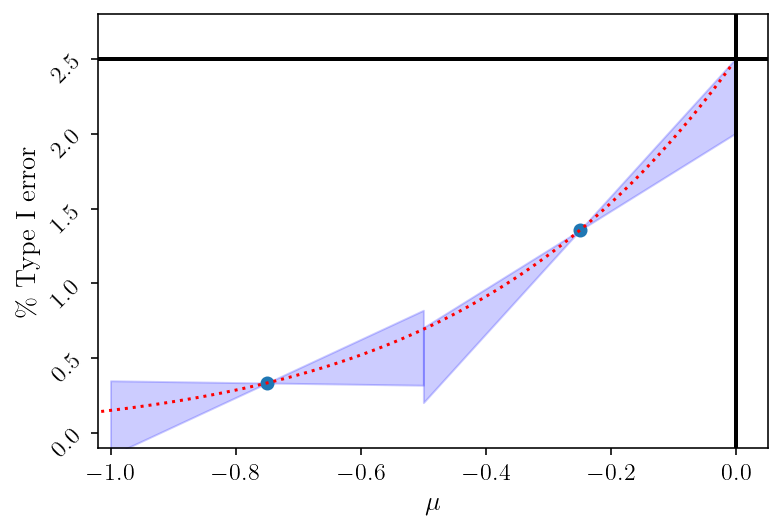

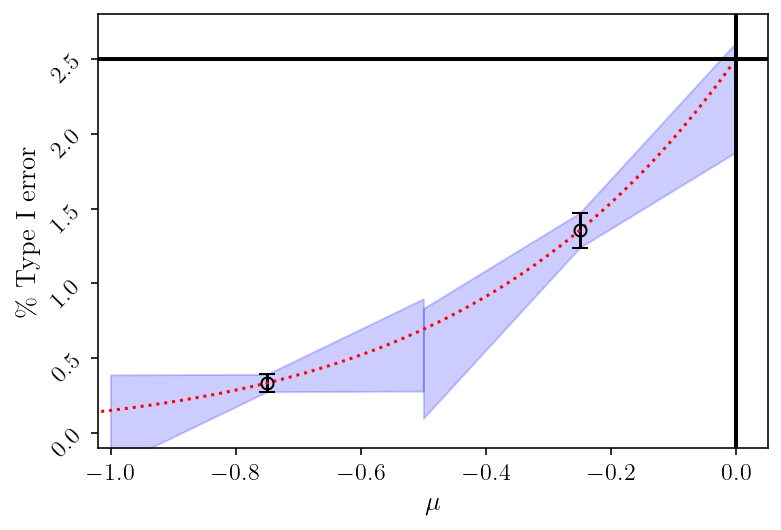

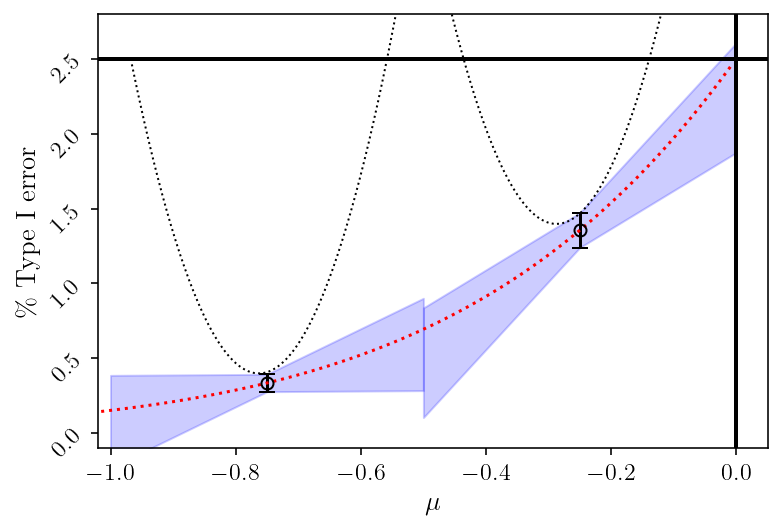

In [61]:
def fig3(include_ptwise_error, include_quadratic, **kwargs):
    npoints = 2
    (
        mu,
        power,
        error,
        CI,
        stepsize,
        bound_xs,
        grad_bound,
        grad_bound_low,
    ) = gradient_bounds(2, int(1e6), include_ptwise_error=include_ptwise_error)

    if include_quadratic:
        mu, power, stepsize, bound_xs2, penalized_bound, penalized_bound_low = build_bounds(npts=npoints, nsims=int(1e6))
        # arbitrary adjustment to get the two curves to line up
        # eventually we should use real imprint for all these figures so that
        # we don't have to do this
        penalized_bound[0] -= 0.0014
        penalized_bound[1] -= 0.001
        full_xs = np.concatenate(bound_xs2)
        full_bound = np.concatenate(penalized_bound)
        filter = (full_xs > -0.8) | (full_bound < 0.025)
        plt.plot(full_xs[filter], full_bound[filter], 'k:', linewidth=1)
    for i in range(npoints):
        plt.fill_between(
            bound_xs[i], grad_bound_low[i], grad_bound[i], color="b", alpha=0.2
        )
    plot_power_pts(mu, power, error, CI)
    plt.plot(mu_dense10, pow_dense10, "r:")
    set_domain(**kwargs)


fig3(False, False)
plt.show()
fig3(True, False)
plt.show()
fig3(True, True)
plt.show()

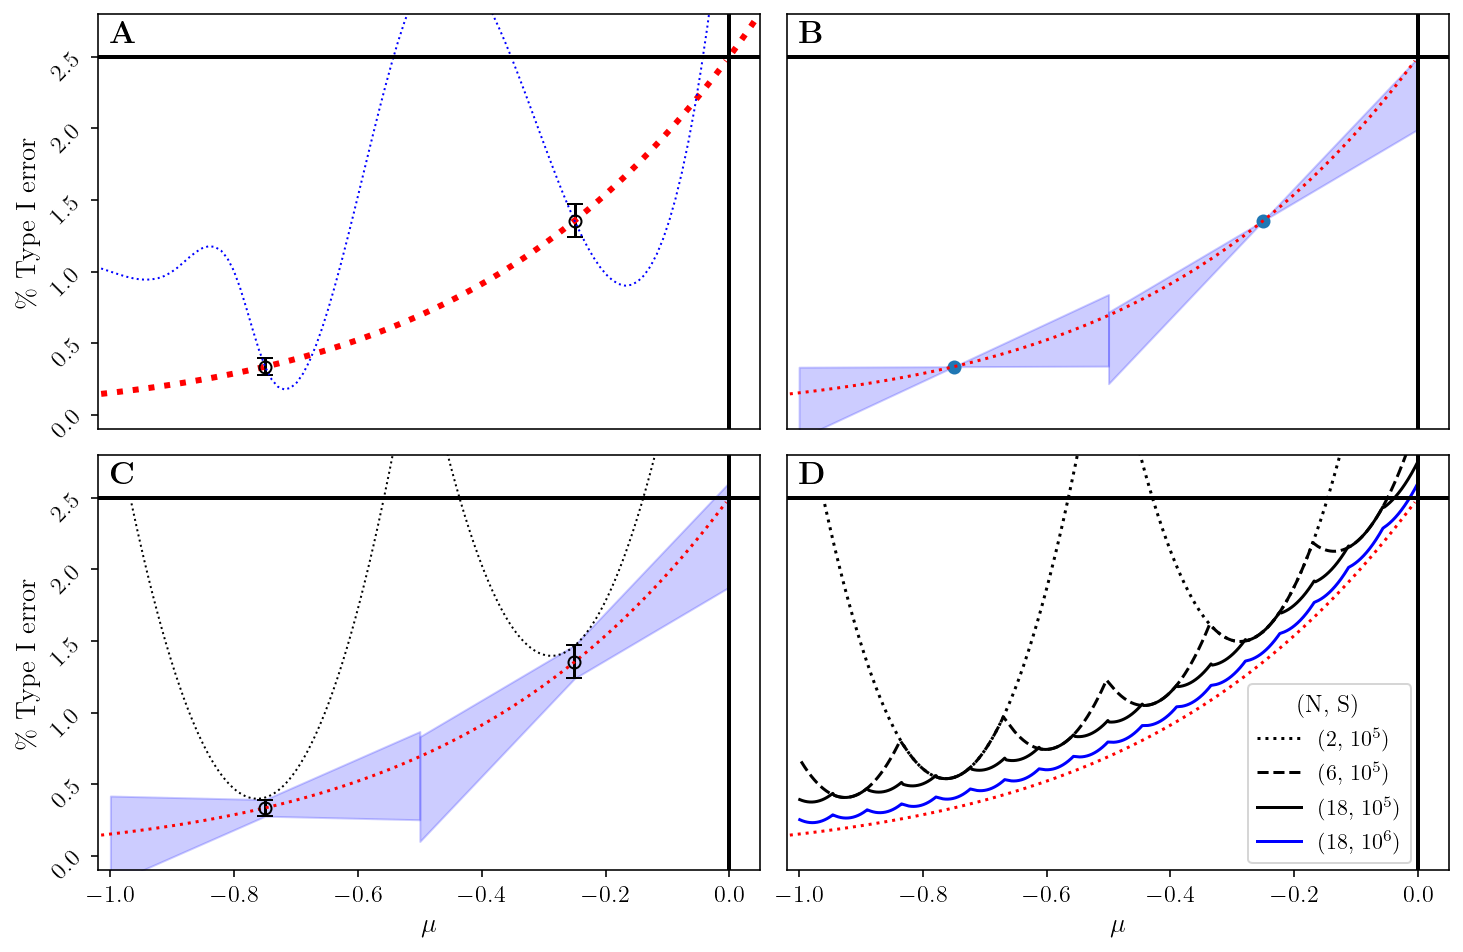

In [62]:
import matplotlib.patches as patches

ratio = 8.5 / 5.5
h = 6.5
plt.figure(figsize=(ratio * h, h), constrained_layout=True)
plt.subplot(2,2,1)
fig1(True, skipx=True)
plt.text(-1, 0.026, "$\mathbf{A}$", fontsize=16)
plt.subplot(2,2,2)
fig3(False, False, skipx=True, skipy=True)
plt.text(-1, 0.026, "$\mathbf{B}$", fontsize=16)
plt.subplot(2,2,3)
fig3(True, True)
plt.text(-1, 0.026, "$\mathbf{C}$", fontsize=16)
plt.subplot(2,2,4)
fig2(skipy=True)
t = plt.text(-1, 0.026, "$\mathbf{D}$", fontsize=16)
plt.show()